In [1]:
import uproot
import matplotlib.pyplot as plt
import numpy as np


In [2]:
# Set rangdom seed (while we are not using it, probably)
np.random.seed(1)

# The first two events are not with data
first_good_event=2

num_channels = 128

# Open file
#events = uproot.open("003200_v9_hists.root")["events"]
events = uproot.open("D:\\data\\gemtrd\\003200_v10_hists.root")["events"]

# Uncomment to see file contents
# events.keys()

In [3]:
# GET NUMBER OF TIME BINS
# Now we need to extract number of time-bins for each channel.
# The number is actually the same for the whole run, so we need to get only one element
# So we taking 1st element from 1st event we read (1st and the only event)
num_time_bins=events['srs_raw_samples_count'].array(library="np", entry_start=first_good_event, entry_stop=first_good_event+1)[0][0]
print(f"Number of time bins: {num_time_bins}")

Number of time bins: 6


In [4]:
entry_start = 2
entry_stop = entry_start + 1000
# 'srs_raw_channel',
# 'srs_raw_apv_id',
# 'srs_raw_channel_apv',
# 'srs_raw_best_sample',
# 'srs_raw_samples_index',
# 'srs_raw_samples_count',

all_samples =  events['srs_raw_samples'].array(library="np", entry_start=entry_start, entry_stop=entry_stop)

# Get number of APVs
num_apvs = int(len(all_samples[0])/num_time_bins/num_channels)
print(f"Number of APVs: {num_apvs}")


Number of APVs: 7


In [5]:
# GET CHANNEL MAPPING
# srs_raw_channel_apv contains correct order of channels for each apv. I.e. MAPPING
# Since the mapping is the same for each apv, we need just one mapping
# So we take just a single event, first APV and we get a map for 128 channels
ch_mapping = events['srs_raw_channel_apv'].array(entry_start=entry_start, entry_stop=entry_start + 1)

# Convert it to (events:apv:channel) shape:
ch_mapping = np.reshape(ch_mapping, (len(ch_mapping), num_apvs, num_channels))

# Now only take the last dimension and convert it to numpy
ch_mapping = np.array(ch_mapping[0][0])

# Uncomment to see the mapping
# print(f"Channel mappings is: {channel_mapping}")

In [6]:
type(events)

uproot.models.TTree.Model_TTree_v20

In [7]:
#apvs = events['srs_raw_channel'].array(library="np", entry_start=entry_start, entry_stop=entry_stop)


## Explanation of data: 
We have data in *srs_raw_samples* that looks like this (**num_time_bins=3**)
```
[
  [2820, 2810, 2717, 2774,  ...],  # event 0
  [2886, 2814, 2757, 2833,  ...],  # event 1
  ...
]
```
The values correspond to apv:channel:time-bin
Imagine we have 3 time bins, then the previous data for a single event (1 row) will correspond to

```
[apv0:ch0:t0, apv0:ch0:t1, apv0:ch0:t2, apv0:ch1:t0 ... apv0:ch128:t2, apv1:ch0:t0, ...]
```

Now we want to reshape this array so that time bins are a separate arrays of each channel
i.e. we had `[[1,2,3,4,5,6], ...]` we want `[[[1,2,3],[4,5,6]], ...]`
To do this we use `array.reshape((n_events, n_apvs*n_channels, n_time_bins))`

```python
expl_array = np.array([[1,2,3,4,5,6],[7,8,9,10,11,12]])
reshape_tuple = (len(expl_array), int(len(expl_array[0])/3), 3)
expl_array = expl_array.reshape(reshape_tuple)
```

That would give us: 

```
array([[[ 1,  2,  3],
        [ 4,  5,  6]],

       [[ 7,  8,  9],
        [10, 11, 12]]])
```

In [8]:
reshape_tuple = (len(all_samples), num_apvs, num_channels, num_time_bins)
print(f"Reshaping {np.shape(np.vstack(all_samples))} to {reshape_tuple}")
channel_data = np.vstack(all_samples).reshape(reshape_tuple)
channel_data.shape

Reshaping (1000, 5376) to (1000, 7, 128, 6)


(1000, 7, 128, 6)

In [9]:
# Compute the mean over the 0-th and 3-rd axes
pedestals = np.mean(channel_data, axis=(0, 3))
pedestals

array([[2802.61083333, 2880.00033333, 2891.51383333, 2909.76016667,
        2974.69183333, 2942.37233333, 2938.58916667, 2913.39983333,
        2944.411     , 2938.85866667, 2912.21466667, 2913.19616667,
        2948.28066667, 2940.4145    , 2921.26916667, 2912.08483333,
        2934.6795    , 2959.80083333, 2925.02616667, 2917.13966667,
        2970.97383333, 2947.129     , 2913.198     , 2898.3925    ,
        2935.23183333, 2936.257     , 2903.89333333, 2889.39116667,
        2935.25083333, 2902.7315    , 2913.18483333, 2894.09233333,
        2962.24416667, 2945.9505    , 2924.5845    , 2924.332     ,
        2973.89116667, 2934.24283333, 2929.52916667, 2904.21783333,
        2941.41283333, 2924.5885    , 2919.05666667, 2892.95483333,
        2949.52016667, 2903.51466667, 2907.76866667, 2893.53683333,
        2952.70533333, 2953.36783333, 2910.7375    , 2917.39066667,
        2954.6285    , 2946.279     , 2915.83733333, 2908.632     ,
        2957.85583333, 2923.07516667, 2904.65483

<BarContainer object of 128 artists>

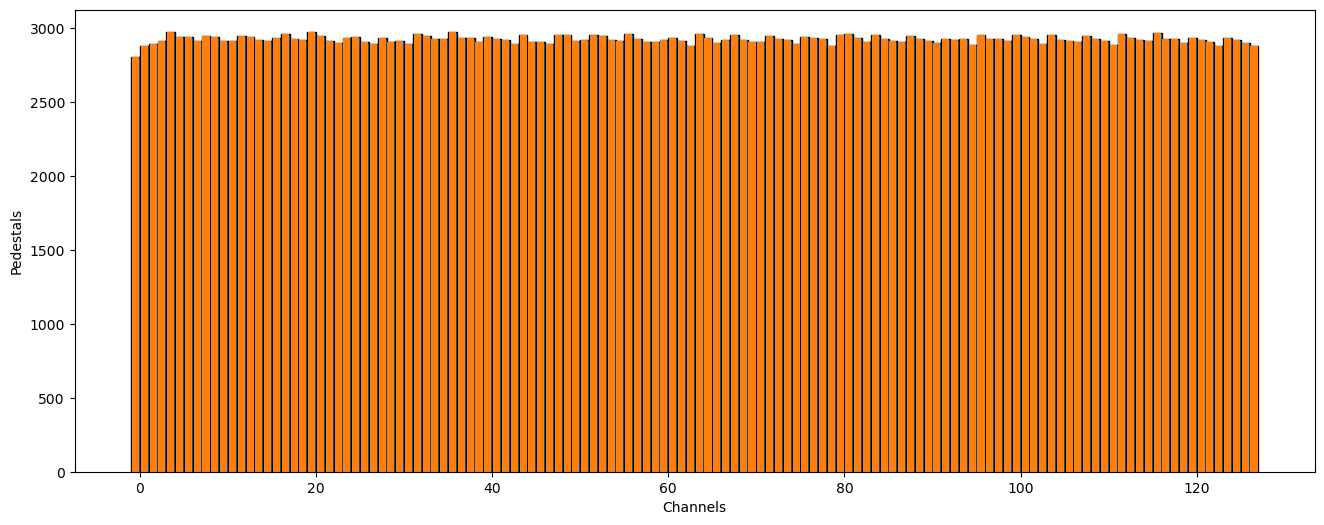

In [10]:
# Generate x values
x_values = np.arange(128) - 0.5

# Create the figure and axes objects
fig, ax = plt.subplots(figsize=(16, 6))  # You can specify your figure size here

# Create the bar plot on the axes object
ax.bar(x_values, pedestals[0], width=1.0, edgecolor='black')

# Set axis titles
ax.set_xlabel('Channels')
ax.set_ylabel('Pedestals')

plt.bar(np.arange(128) - 0.5, pedestals[0])#, where='post')

In [11]:

# Reshape mean_array for broadcasting
mean_array_reshaped = pedestals[:, :, np.newaxis]

# Subtract mean_array from every element in array across the 0-th and 3-rd axes
array_centered = -1*(channel_data - mean_array_reshaped)

# Verify the operation
array_centered.shape

(1000, 7, 128, 6)

In [12]:
#np.transpose(array_centered, (0,1,3,2)).reshape(len(array_centered),num_apvs, num_channels*num_time_bins)
flattened = np.transpose(channel_data, (0,1,3,2)).reshape(len(array_centered),num_apvs, num_channels*num_time_bins)
flattened.shape

(1000, 7, 768)

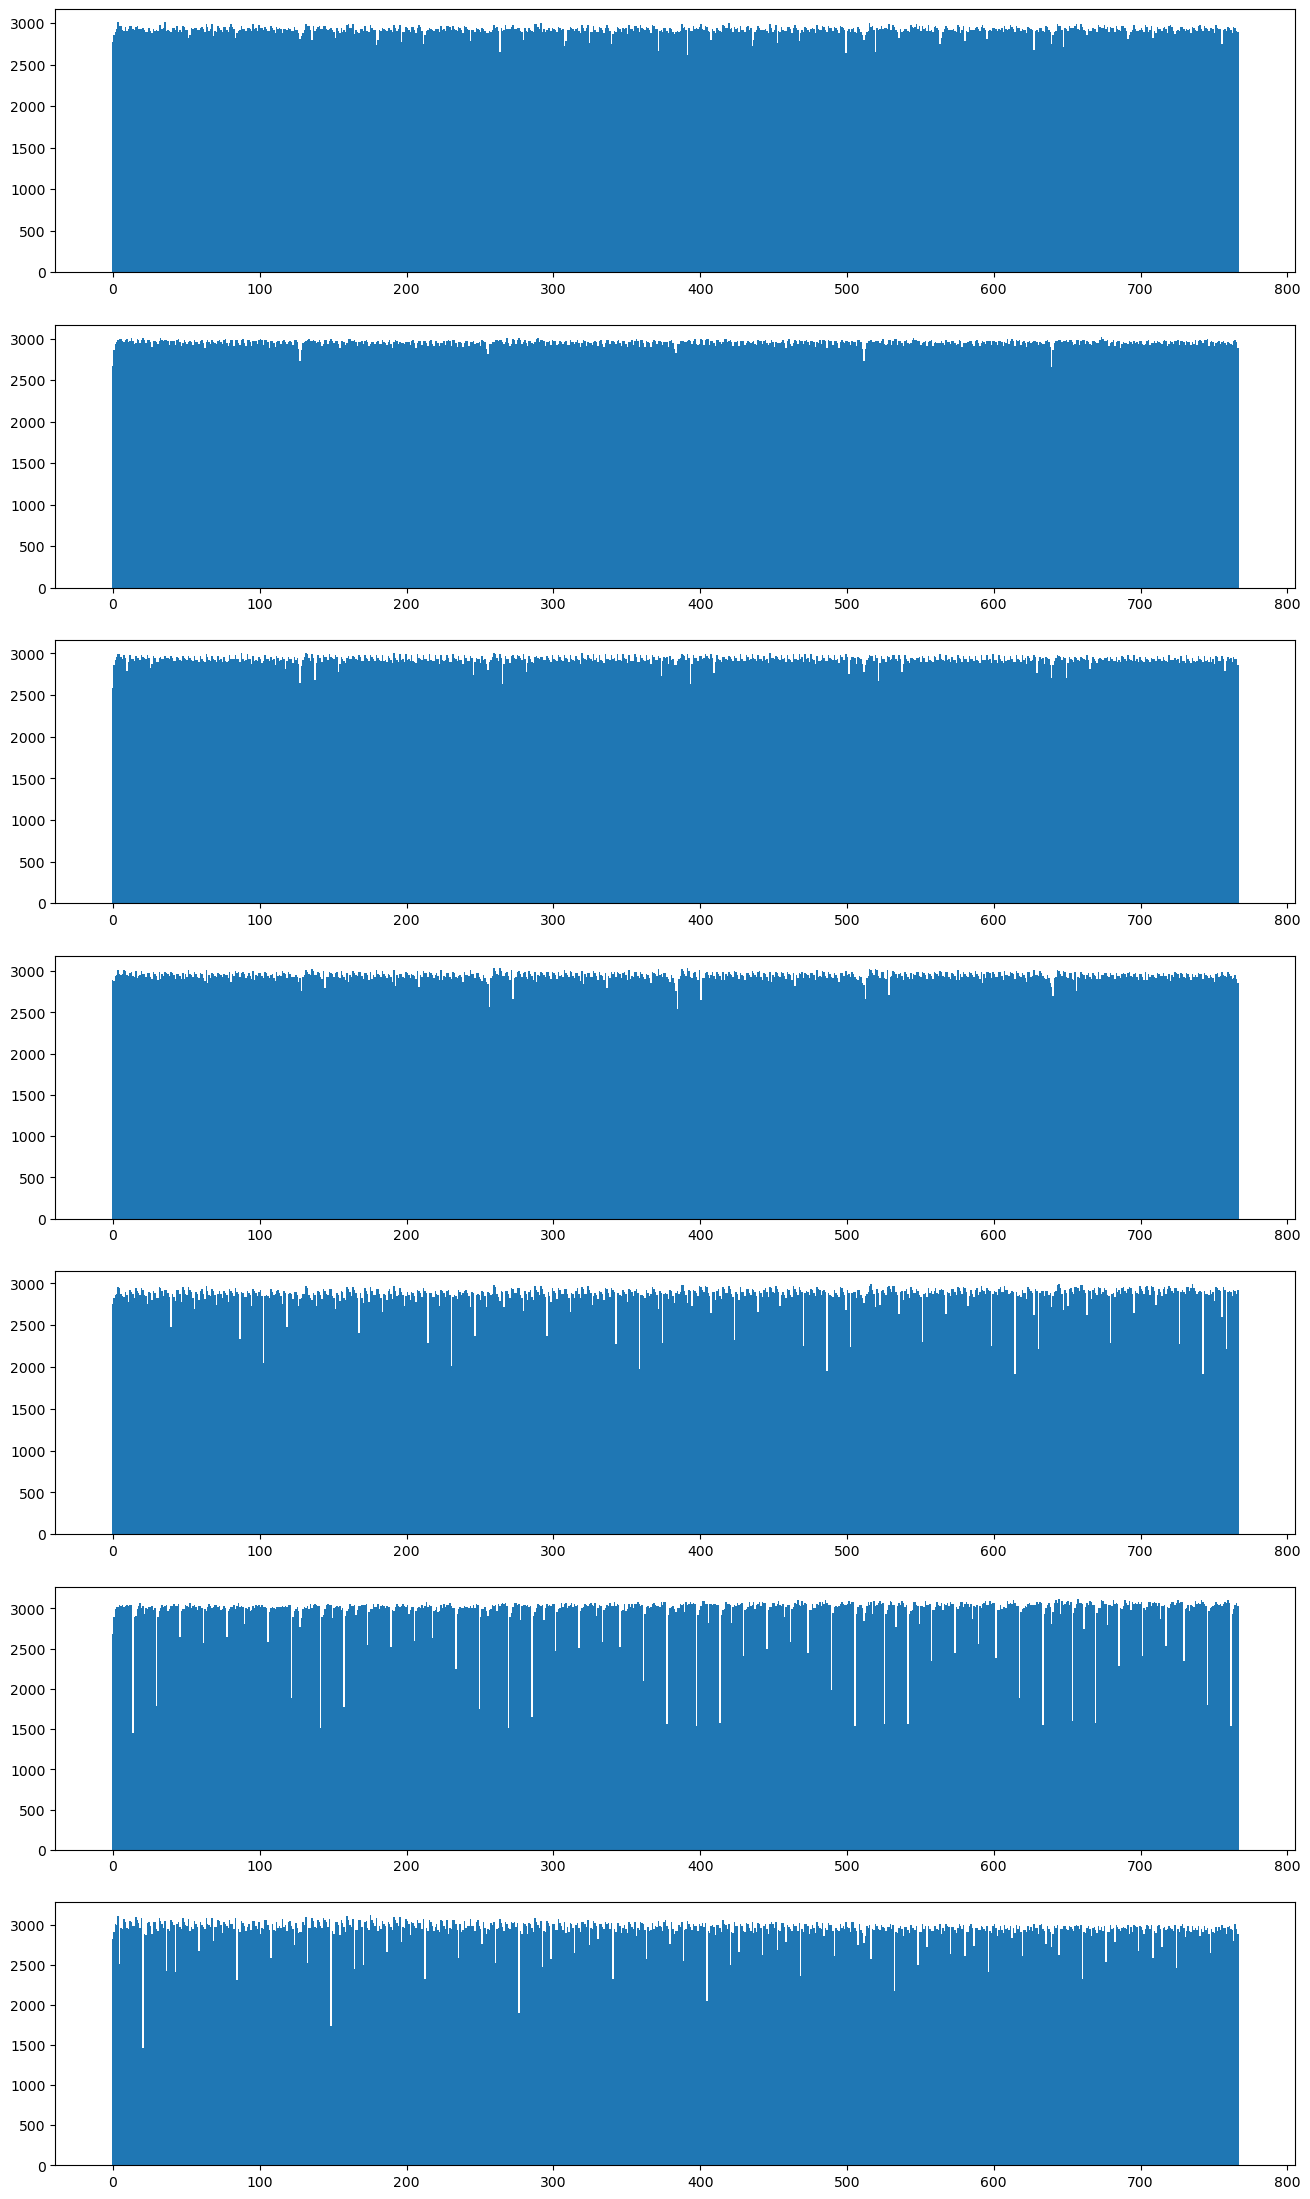

In [13]:
# Generate x values
x_values = np.arange(num_channels*num_time_bins) - 0.5

# Create the figure and axes objects
fig, axes = plt.subplots(num_apvs, 1, figsize=(16, 4*num_apvs))  # You can specify your figure size here
axes
for i,ax in enumerate(axes.flat):
    ax.bar(x_values, flattened[5][i], width=1)
    # Create the bar plot on the axes object
    #ax.bar(x_values, flattened[4][2], width=1)
    
    # Set axis titles
    #ax.set_xlabel('Channels')
    #ax.set_ylabel('Pedestals')

#plt.bar(np.arange(128) - 0.5, pedestals[0])#, where='post')

In [14]:
# channel_data is of shape (1000, 7, 128, 6), the ch_mapping is (128) w
# We will sort along the third axis using the indices from ch_mapping
sorted_array = np.take_along_axis(channel_data, ch_mapping[np.newaxis, np.newaxis, :, np.newaxis], axis=2)

# Verify the shape of the sorted array
sorted_array.shape

(1000, 7, 128, 6)

In [19]:
full_apv = (np.transpose(sorted_array, (0,1,3,2))
            .reshape(len(sorted_array),num_apvs, num_channels*num_time_bins))
full_apv.shape

(1000, 7, 768)

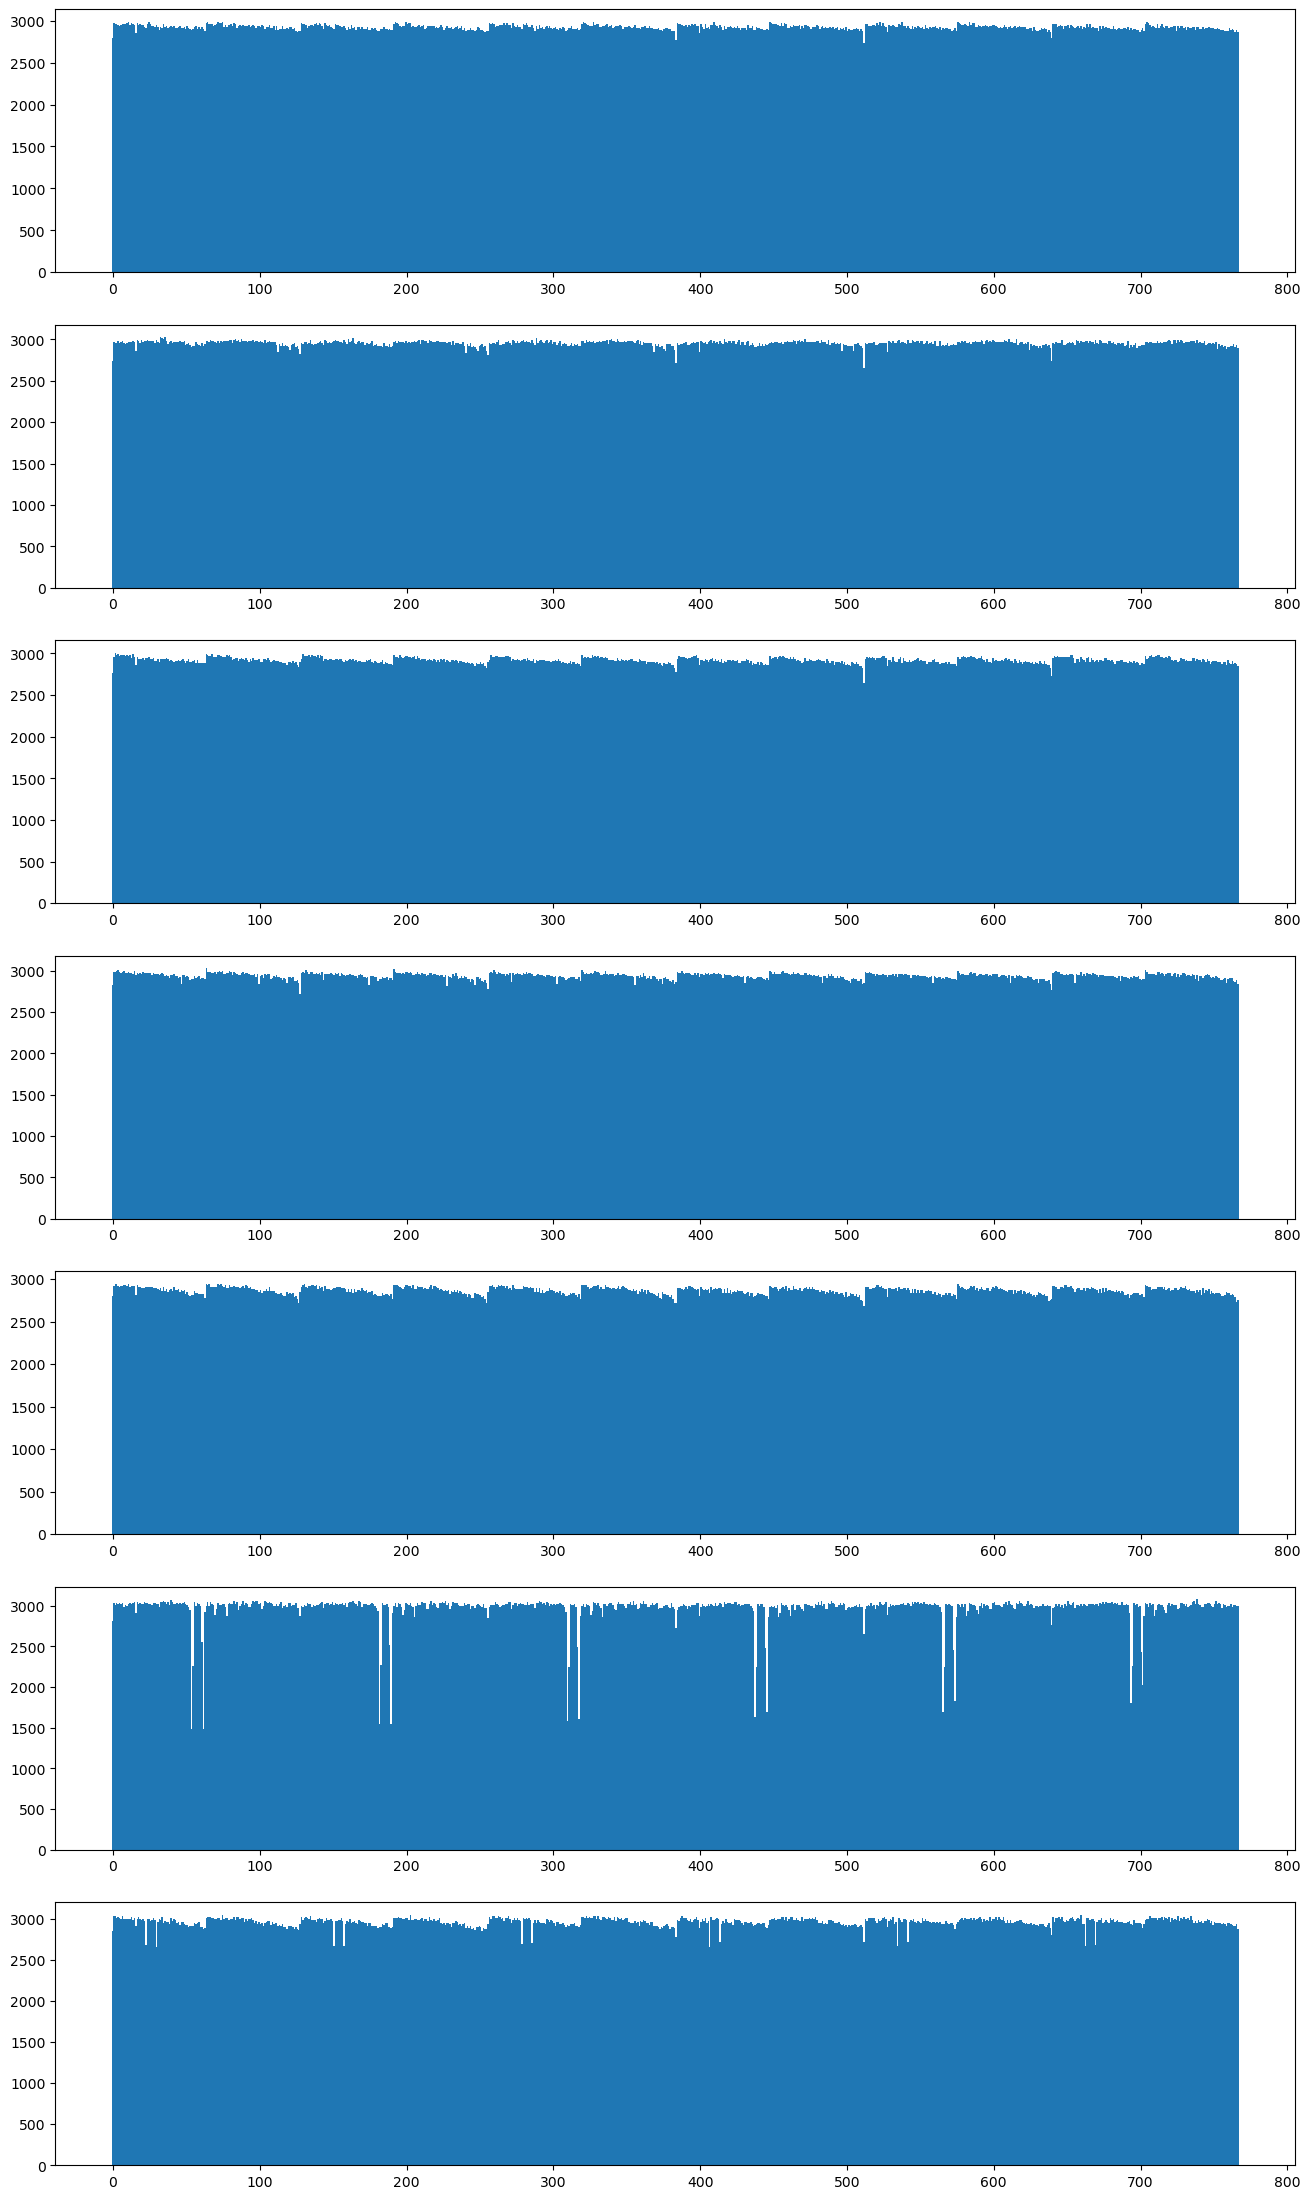

In [23]:
x_values = np.arange(num_channels*num_time_bins) - 0.5

# Create the figure and axes objects
fig, axes = plt.subplots(num_apvs, 1, figsize=(16, 4*num_apvs))  # You can specify your figure size here
for i,ax in enumerate(axes.flat):
    ax.bar(x_values, full_apv[500][i], width=1)

NameError: name 'all2' is not defined

In [ ]:
# Creating a 3D array for demonstration
array = np.array([[[1, 2, 3], [4,5,6]], [[7,8, 9], [10,11,12]]])

# Transpose the array over the second and third axes
transposed_array = np.transpose(array, (0, 2, 1))

# Reshape each 2x2 sub-array into a 1D array
result_array = transposed_array.reshape(transposed_array.shape[0], -1)

result_array